In [1]:
pip install xgboost

## test Linear Regression, Random Forest, và XGBoost

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer

# Check if xgboost library is installed / Kiểm tra xem thư viện xgboost có được cài đặt không
try:
    from xgboost import XGBRegressor
    xgboost_installed = True
except ModuleNotFoundError:
    print("⚠️ Warning: 'xgboost' library is not installed. Please install it using: pip install xgboost")
    xgboost_installed = False


In [3]:
# 1️⃣ Load data from test.csv with appropriate encoding / Tải dữ liệu từ test.csv với encoding thích hợp
try:
    df = pd.read_csv("test.csv", encoding="euc-kr")
except UnicodeDecodeError:
    df = pd.read_csv("test.csv", encoding="ISO-8859-1")


In [4]:
# 2️⃣ Check initial dataset information / Kiểm tra thông tin dữ liệu ban đầu
print("Dataset Information:")
print(df.info())
print("\nPreview Data:")
print(df.head())

# Convert object columns to numeric if applicable / Chuyển đổi các cột object thành kiểu số nếu có thể
numeric_columns = ["Total_Emp", "Actual_Emp", "Avg_Temp", "previous_orders"]
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                1205 non-null   object 
 1   Day                 1205 non-null   object 
 2   Total_Emp           1205 non-null   int64  
 3   Actual_Emp          1205 non-null   int64  
 4   Leave_Emp           1205 non-null   int64  
 5   Trip_Emp            1205 non-null   int64  
 6   OT_Approved         1205 non-null   int64  
 7   Remote_Emp          1205 non-null   int64  
 8   Lunch_Menu          1205 non-null   object 
 9   Dinner_Menu         1205 non-null   object 
 10  Lunch_Count         1205 non-null   int64  
 11  Dinner_Count        1205 non-null   int64  
 12  Holiday             1205 non-null   int64  
 13  Month               1205 non-null   int64  
 14  Date.1              1205 non-null   int64  
 15  Season              1205 non-null 

In [5]:
# 3️⃣ Data preprocessing / Tiền xử lý dữ liệu
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df.dropna(subset=['Date'], inplace=True)


In [6]:
# 4️⃣ Check and handle missing values / Kiểm tra và xử lý giá trị thiếu
print("\nMissing Values Count:")
print(df.isnull().sum())

# Fill missing values with column mean / Điền giá trị thiếu bằng giá trị trung bình
for col in df.select_dtypes(include=[np.number]).columns:
    df[col].fillna(df[col].mean(), inplace=True)



Missing Values Count:
Date                     0
Day                      0
Total_Emp                0
Actual_Emp               0
Leave_Emp                0
Trip_Emp                 0
OT_Approved              0
Remote_Emp               0
Lunch_Menu               0
Dinner_Menu              0
Lunch_Count              0
Dinner_Count             0
Holiday                  0
Month                    0
Date.1                   0
Season                   0
Lunch_Rice               0
Lunch_Soup               1
Lunch_Main_Dish          2
Lunch_Side_Dish_1        0
Lunch_Side_Dish_2        5
Lunch_Drink           1107
Lunch_Kimchi             2
Lunch_side_Dish_3     1067
Dinner_Rice             42
Dinner_Soup             41
Dinner_Main_Dish        24
Dinner_Side_Dish_1      35
Dinner_Side_Dish_2    1025
Dinner_Side_Dish_3     222
Dinner_Drink          1186
Dinner_Kimchi           47
Station                  0
Avg_Temp                 0
Max_Temp                 1
Max_Temp_Time            1
Min_T

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16836\4237837712.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


In [7]:
# 5️⃣ Encode dish data using TF-IDF if column 'Lunch_Menu' exists / Mã hóa dữ liệu món ăn bằng TF-IDF nếu có cột 'Lunch_Menu'
if 'Lunch_Menu' in df.columns:
    vectorizer = TfidfVectorizer()
    X_dish = vectorizer.fit_transform(df["Lunch_Menu"].astype(str))


In [8]:
# 6️⃣ Select relevant features if available / Chọn các đặc trưng phù hợp nếu có
features = [col for col in ["day_of_week", "month", "Avg_Temp", "Holiday", "previous_orders"] if col in df.columns]
X = df[features] if features else None
y = df["Lunch_Count"] if "Lunch_Count" in df.columns else None

if X is None or y is None or X.empty or y.empty:
    raise ValueError("Insufficient data for model training. / Dữ liệu không đủ để huấn luyện mô hình.")


In [9]:
# 7️⃣ Split train/test dataset / Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# 8️⃣ Initialize prediction models / Khởi tạo các mô hình dự đoán
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

if xgboost_installed:
    models["XGBoost"] = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)


In [11]:
# 9️⃣ Train and evaluate models / Huấn luyện và đánh giá các mô hình
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)  # Train model / Huấn luyện mô hình
    y_pred = model.predict(X_test)  # Predict results / Dự đoán kết quả
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = {"MSE": mse, "MAE": mae}
    
    print(f"{name} - MSE: {mse:.4f}, MAE: {mae:.4f}")

Linear Regression - MSE: 17866.6981, MAE: 99.7860
Random Forest - MSE: 16446.7781, MAE: 91.9047
XGBoost - MSE: 16536.3203, MAE: 89.8103


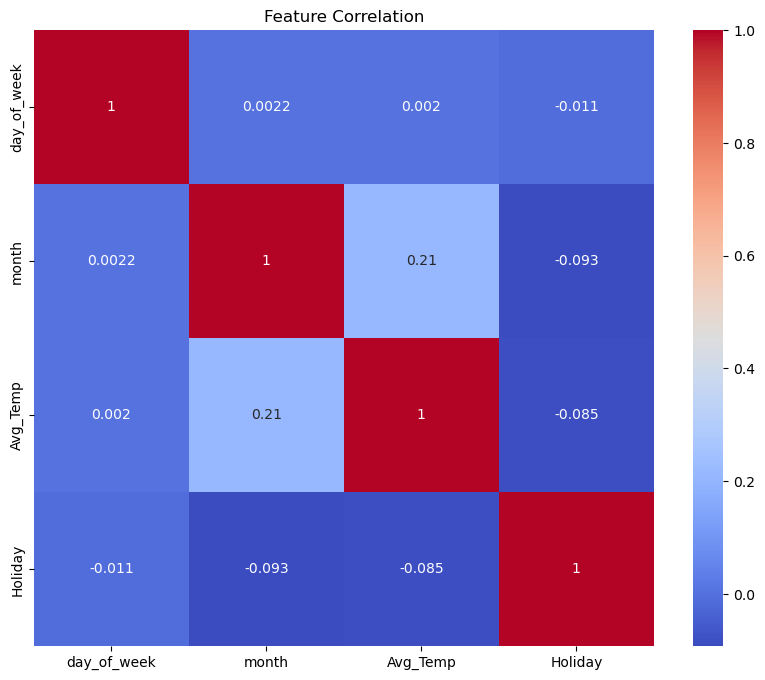

In [12]:
# 🔟 Display feature correlation if sufficient data is available / Biểu diễn tương quan giữa các đặc trưng nếu có đủ dữ liệu
if len(features) > 1:
    plt.figure(figsize=(10, 8))
    sns.heatmap(X.corr(), annot=True, cmap="coolwarm")
    plt.title("Feature Correlation")
    plt.show()


In [13]:
# 1️⃣1️⃣ Identify the best model and suggest improvements / Xác định mô hình tốt nhất và đề xuất cải thiện
best_model = min(results, key=lambda x: results[x]["MSE"])
print(f"Best Model: {best_model}")


Best Model: Random Forest


## tối ưu và triển khai mô hình Random Forest:

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Giả sử bạn có dữ liệu X và y
# X = các đặc trưng, y = nhãn (target)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tạo mô hình Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Huấn luyện mô hình với dữ liệu huấn luyện
rf_model.fit(X_train, y_train)  # Train the model


RandomForestRegressor(random_state=42)

In [16]:
# phân tích sai số 
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Dự đoán trên dữ liệu kiểm tra
y_pred = rf_model.predict(X_test)  # Prediction on test data

# Tính MSE và MAE
mse = mean_squared_error(y_test, y_pred)  # MSE calculation
mae = mean_absolute_error(y_test, y_pred)  # MAE calculation

# In ra kết quả
print(f'MSE: {mse}, MAE: {mae}')  # Output MSE and MAE


MSE: 16446.778115761066, MAE: 91.9047213001383
